# Generative Modelling with VAEs, GANs and Autoregressive Models

From a practical perspective, neural networks have primarily been used for supervised learning, with applications ranging from activity recognition in videos to language translation. However, labelled data is sparse or nonexistent in many situations, so we'd like to make use of unsupervised learning to make sense of the vast amount of unlabelled data in the world. Here we'll look at three types of deep generative models - variational autoencoders (VAEs), generative adversarial networks (GANs), and autoregressive models - that can learn to generate samples from a dataset.

## Data

We'll use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which comprises of 70,000 28x28 grayscale images of handwritten digits. Apart from the underlying classes (0-9), there's a bunch of factors of variation such as line thickness and slant:

![MNIST samples](https://qph.fs.quoracdn.net/main-qimg-d01751bdf7dab3d9a5949f226a35b7ba)

This dataset is relatively easy to model, so we'll do so with the 60,000 samples from the training set.

In [1]:
import math
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.distributions import Normal
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from IPython.display import clear_output, display
%matplotlib inline

In [2]:
latent_size = 10
batch_size = 64

data_path = os.path.join(os.path.expanduser('~'), '.torch', 'datasets', 'mnist')
train_data = datasets.MNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(data_path, train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=4)

## VAEs

### Model

The VAE (somewhat misnamed) consists of an autoencoder with a stochastic bottleneck layer, trained via variational inference. The encoder and decoder will make use of convolutions and transposed (also known as fractionally-strided) convolutions, respectively. The latent encoding in the middle of the autoencoder - the variational posterior - will be a simple diagonal covariance Gaussian. In addition, we'll make use of the "reparameterisation trick", where the stochastic latents are decomposed into a combination of deterministic variables and another source of noise - so there is no longer a need to devise a gradient estimator for backpropagating through a sampling process. There exist such formulae for several continuous distributions, as well as some for relaxed versions of discrete distributions.

In [5]:
class VAE(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, stride=2, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=2, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.fc_mu = nn.Linear(32 * 4 * 4, latent_size)
        self.fc_log_var = nn.Linear(32 * 4 * 4, latent_size)
        self.fc_dec = nn.Linear(latent_size, 32 * 4 * 4)
        self.conv4 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=2, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(8)
        self.conv6 = nn.ConvTranspose2d(8, 1, 5, stride=2, padding=2, output_padding=1)

    def encode(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)
        mu, log_var = self.fc_mu(x), self.fc_log_var(x) 
        z = mu + log_var.mul(0.5).exp() * torch.randn_like(mu)  # Reparameterisation trick
        return z, mu, log_var
    
    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(-1, 32, 4, 4)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        return torch.sigmoid(self.conv6(x))

    def forward(self, x):
        z, mu, log_var = self.encode(x)
        x = self.decode(z)
        return x, z, mu, log_var

### Training, Sampling and Interpolating

To train the model we will optimise the variational or evidence lower bound (ELBO). The ELBO consists of minimising the reconstruction error of the input sample (as with a normal autoencoder), as well as the Kullback-Leibler (KL) divergence between the variational posterior and the prior - which we set to a unit Gaussian. Because of the form of our prior and posterior we can actually construct an analytical form of the KL divergence to minimise.

Once the model is trained we can sample a latent code from our prior and pass this through the decoder to form a sample of the data. Although the posterior may not match the prior, this is an OK assumption to make. Other than picking random samples, we can also pick a dimension of the latent code to interpolate in (keeping all other dimensions fixed), which would reveal what that dimension is coding for. We'll plot random samples on the left and interpolations on the right. Note that while people typically take the mean of the encoded sample for reconstructing test samples during evaluation, the sampling in the latent space should still occur if evaluating the ELBO on the test set.

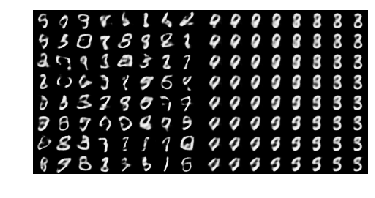

In [6]:
plt.axis('off')

model = VAE(latent_size)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
z_samples = torch.randn(64, latent_size)
z_interp = torch.zeros(64, latent_size)
grid_x, grid_y = torch.meshgrid([torch.linspace(-1.5, 1.5, 8), torch.linspace(-1.5, 1.5, 8)])
z_interp[:, 0] = grid_y.contiguous().view(-1)
z_interp[:, 1] = grid_x.contiguous().view(-1)
black_bar = torch.zeros(3, 8 * 28, 10)

def train(model, optimiser):
    model.train()
    for i, (x, _) in enumerate(train_loader):
        optimiser.zero_grad()
        x_hat, z, mu, log_var = model(x)
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')  # Reconstruction loss
        kld = -0.5 * torch.sum(-log_var.exp() - mu ** 2 + log_var + 1)  # KL divergence
        (recon_loss + kld).div(batch_size).backward()
        optimiser.step()

def sample(model):
    model.eval()
    with torch.no_grad():
        samples = make_grid(model.decode(z_samples), padding=0)
        interps = make_grid(model.decode(z_interp), padding=0)
        plt.imshow(np.transpose(torch.cat([samples, black_bar, interps], 2).numpy(), [1, 2, 0]))
        clear_output(wait=True)
        display(plt.gcf())

for _ in range(epochs):
    train(model, optimiser)
    sample(model)
clear_output(wait=True)

To see how latent samples from the prior may differ from latent samples from the learned posterior, we can feed the first batch of generated data samples into the network repeatedly. This acts as a form of Markov chain Monte Carlo (MCMC) sampling, making both the latent and data samples more likely under the model. With just a few steps of MCMC sampling, the new data samples are more recognisable as digits, but also less diverse.

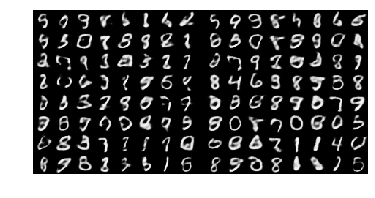

In [7]:
plt.axis('off')

model.eval()
with torch.no_grad():
    orig_samples = model.decode(z_samples)
    samples = orig_samples
    for _ in range(10):
        samples = model(samples)[0]
    orig_samples = make_grid(orig_samples, padding=0)
    samples = make_grid(samples, padding=0)
plt.imshow(np.transpose(torch.cat([orig_samples, black_bar, samples], 2).numpy(), [1, 2, 0]))
display(plt.gcf())
clear_output(wait=True)

### IWAE

The importance weighted autoencoder (IWAE) uses the same model (network architecture) as the VAE, but proposes a tighter ELBO to maximise. This makes use of several independent samples at once, so reduces to the original VAE ELBO with only one sample, but approaches the true log probability of the data as the number of samples increase. While the original ELBO penalises all samples equally, the importance-weighted objective is primarily influenced by the "best" samples, allowing the other samples to spread over the true posterior. The downside is that the signal-to-noise ratio decreases for the inference network (encoder) as the number of samples increases, so in practice the IWAE ELBO is good to measure, but may not be good for training (we'll load in the full minibatch but actually use 4 samples per IWAE loss in order to mitigate this effect somewhat). In addition, the more powerful posterior may lie even further away from the prior, making sampling from the prior even more questionable.

We will now need to use a Monte Carlo estimator of the KL divergence in order to perform the importance weighting. However, we can reduce the variance of this estimator by using the *path derivative* estimator - where we do not backpropagate through the parameters of the variational probability distribution, but only the sample itself (which can still be formed via the reparameterisation trick).

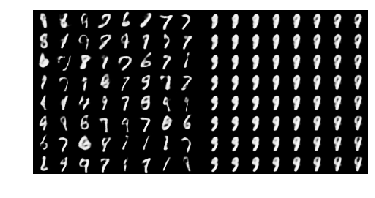

In [8]:
plt.axis('off')

model = VAE(latent_size)
optimiser = optim.Adam(model.parameters(), lr=1e-3)
prior = Normal(torch.zeros(1), torch.ones(1))
k = 4

def log_mean_exp(x, dim=1):
    x_max = x.max(dim=dim, keepdim=True)[0]
    return x_max + torch.log(torch.mean(torch.exp(x - x_max), dim=dim, keepdim=True))

def train(model, optimiser):
    model.train()
    for i, (x, _) in enumerate(train_loader):
        optimiser.zero_grad()
        x_hat, z, mu, log_var = model(x)
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction='none').view(-1, 28 ** 2).sum(1)  # Reconstruction loss
        kld = (Normal(mu.detach(), log_var.detach().mul(0.5).exp()).log_prob(z) - prior.log_prob(z)).sum(1)  # KL divergence
        iwae_samples = (recon_loss + kld).view(batch_size // k, -1)
        (-log_mean_exp(-iwae_samples)).mean().backward()  # IWAE loss; VAE loss would be (recon_loss - kld).mean()
        optimiser.step()        

for _ in range(epochs):
    train(model, optimiser)
    sample(model)
clear_output(wait=True)

## GANs

### Models

GANs involve two separate models - a generator and a discriminator - trained via a two-player zero sum game. The generator is an implicit generative model that takes a source of noise as input and produces a data sample. The discriminator takes (real or fake) data samples as input and outputs the probability that they are real samples. We can construct the generator out of transposed convolutions and the discriminator out of regular convolutions; in particular, we'll follow some architectural choices proposed under the name of "deep convolutional generative adversarial network" (DCGAN).

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size
        self.conv1 = nn.ConvTranspose2d(latent_size, 32, 4, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=2, output_padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.ConvTranspose2d(8, 1, 4, stride=2, padding=1)

    def forward(self, z):
        z = z.view(-1, self.latent_size, 1, 1)
        x = F.relu(self.bn1(self.conv1(z)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return torch.sigmoid(self.conv4(x))


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, 4, stride=2, padding=1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        return torch.sigmoid(self.conv4(x)).view(-1)

### Training, Sampling and Interpolating

GANs are trained using a minimax loss - the discriminator is trained to maximise the probability that it makes the correct binary classification (equivalent to density ratio estimation) on data samples, while the generator is trained to minimise this. The first stage of training therefore involves training the discriminator to correctly classify both real and fake samples. The second stage involves training the generator to make the discriminator think its samples are actually real.

Ideally, as the discriminator gets better at separating real and fake samples, the generator also becomes better at fooling the discriminator with more convincing samples. The goal is to find a Nash equilibrium, which corresponds to minimising the Jensen-Shannon divergence between the real and generator data distributions. In practice the adversarial game makes training difficult. Much research has focused on alleviating this, primarily through the use of weight or gradient penalties.

Because the generator is trained directly on a fixed noise distribution, (if trained properly) we should be able to generate samples without worrying about any mismatches in the latent samples. Interpolation will also work as before.

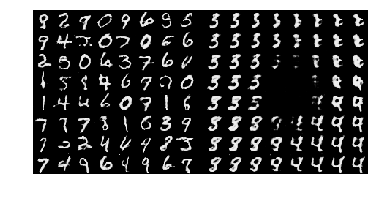

In [10]:
plt.axis('off')

generator, discriminator = Generator(latent_size), Discriminator()
gen_optimiser = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
disc_optimiser = optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))

def train(generator, discriminator, gen_optimiser, disc_optimiser):
    for i, (real_x, _) in enumerate(train_loader):
        disc_optimiser.zero_grad()
        # Train discriminator to identify real data
        real_y = discriminator(real_x)
        real_loss = F.binary_cross_entropy(real_y, torch.ones_like(real_y))
        real_loss.backward()
        # Train discriminator to identify fake data
        noise = torch.randn(batch_size, latent_size)
        fake_x = generator(noise)
        fake_y = discriminator(fake_x.detach())
        fake_loss = F.binary_cross_entropy(fake_y, torch.zeros_like(fake_y))       
        fake_loss.backward()
        disc_optimiser.step()

        gen_optimiser.zero_grad()
        # Train generator to fool discriminator on fake data
        fake_y = discriminator(fake_x)
        fake_loss = F.binary_cross_entropy(fake_y, torch.ones_like(fake_y))       
        fake_loss.backward()
        gen_optimiser.step()        


def sample(generator):
    generator.eval()
    with torch.no_grad():
        samples = make_grid(generator(z_samples), padding=0)
        interps = make_grid(generator(z_interp), padding=0)
        plt.imshow(np.transpose(torch.cat([samples, black_bar, interps], 2).numpy(), [1, 2, 0]))
        clear_output(wait=True)
        display(plt.gcf())
        

for _ in range(epochs):
    train(generator, discriminator, gen_optimiser, disc_optimiser)
    sample(generator)
clear_output(wait=True)

Compare the GAN samples to the VAE samples. Although it isn't a completely fair comparison, VAE samples tend to be more globally coherent, but blurrier. This is because the typical VAE reconstruction loss optimises each pixel independently, leading towards values that kind of work well on average (consider modelling a multimodal distribution with a unimodal distribution). On the other hand, the discriminator is after samples that look like they've come from the real distribution, leading towards finer textures or object boundaries in images.

## Autoregressive Models

Autoregressive models model data using the chain rule for the the joint distribution $p(\mathbf{x}) = \prod_1^n p(x_i|x_{<i})$, which means that every point is dependent on previous ones; these models deal with sequences without a recurrent hidden state, unlike RNNs. Although imposing an ordering on the data distribution, such as the pixels of an image, may seem unnatural, it is perfectly valid, and certainly more powerful than predicting each point independently. This is a powerful technique that allows generative modelling without requiring latent variables (though they can also be used in combination with latent variables), and can consequently be trained exactly on maximum likelihood estimation. The downside is that generating an entire sample happens in this sequential order, which can be slow if the dimensionality of the data is large. Finding ways of capturing the power of autoregressive models while improving sampling, such as using multiscale approaches, is an ongoing area of research.

### Model

There are many autoregressive models that can model image data, and we'll look at a relatively simple one known as the PixelCNN. The PixelCNN is a fully convolutional model that uses *causal convolutions* in order to enforce the dependencies in the data. This is achieved by masking the activations within the network, with "future" locations (think of a TV raster scan) always being zeroed out. The initial convolutional layer uses mask type "A", which prevents activations at a location from looking at the values of the activations directly below it - this prevents the first layer from learning a trivial identity function which copies the training images. Other layers use mask type "B", which can see the activations directly below. Otherwise, the original PixelCNN architecture is a standard fully-convolutional neural network. Another modification that isn't strictly restricted to autoregressive models is the choice to model pixels via a categorical distribution - the pixel values are binned into discrete values. This allows the PixelCNN to better model multimodal distributions.

In [11]:
# Creates causal convolutions: Type A does not take middle pixel below as input, type B does
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Create causal convolution mask (type A or B)
        self.register_buffer('mask', torch.ones(self.weight.data.size()))
        y, x = self.mask.size(2) // 2, self.mask.size(3) // 2
        self.mask[:, :, y + 1:, :].zero_()
        self.mask[:, :, y:, (mask_type == 'A' and x or x + 1):].zero_()

    def forward(self, x):
        # Apply mask at each forward pass
        self.weight.data *= self.mask
        return super().forward(x)

class ResBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.conv1 = nn.Conv2d(2 * hidden_size, hidden_size, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.conv2 = MaskedConv2d('B', hidden_size, hidden_size, 5, padding=2, bias=False)
        self.bn2 = nn.BatchNorm2d(hidden_size)
        self.conv3 = nn.Conv2d(hidden_size, 2 * hidden_size, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(2 * hidden_size)

    def forward(self, x):
        r = self.bn1(self.conv1(F.relu(x)))
        r = self.bn2(self.conv2(F.relu(r)))
        r = self.bn3(self.conv3(F.relu(r)))
        x = r + x
        return x

class PixelCNN(nn.Module):
    def __init__(self, hidden_size, res_blocks, discrete_levels):
        super().__init__()
        self.res_blocks = res_blocks
        # All operations are space-preserving
        self.in_conv = MaskedConv2d('A', 1, 2 * hidden_size, 7, padding=3, bias=False)
        self.in_bn = nn.BatchNorm2d(2 * hidden_size)
        for r in range(1, res_blocks + 1):
            # Use add_module method to register parameters correctly
            self.add_module('res' + str(r), ResBlock(hidden_size))
        self.out_conv1 = MaskedConv2d('B', 2 * hidden_size, hidden_size, 3, padding=1, bias=False)
        self.out_bn1 = nn.BatchNorm2d(hidden_size)
        self.out_conv2 = nn.Conv2d(hidden_size, discrete_levels, 1)

    def forward(self, x):
        x = self.in_bn(self.in_conv(x))
        for r in range(1, self.res_blocks + 1):
            x = getattr(self, 'res' + str(r))(x)
        x = self.out_bn1(self.out_conv1(F.relu(x)))
        x = self.out_conv2(F.relu(x))
        return x

## Training and Sampling

Because of the feedforward nature of the PixelCNN, training (or even log-likelihood evaluation) can happen efficiently in parallel - only a single pass of the network is needed to get the outputs based on the training data. Sampling however is a sequential process that requires sampling one pixel at a time, adding this to the input image, and repeating until the whole image is generated. The benefit of course is that the network is better able to capture local spatial dependencies.

The other decision is how to discretise the data. While there is already a discretisation into 255 different pixel values, for simplicity and speed we will use 8 different values.

We'll need to use GPU acceleration, as networks for autoregressive models are generally quite big to get them to work well.

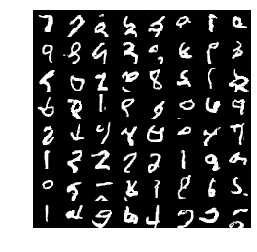

In [12]:
plt.axis('off')

discrete_levels = 8  # Max 256 (long precision)
model = PixelCNN(32, 7, discrete_levels).cuda()
optimiser = optim.Adam(model.parameters(), lr=1e-3)

def train(model, optimiser):
    model.train()
    for i, (x, _) in enumerate(train_loader):
        optimiser.zero_grad()
        discrete_x = x.clone().squeeze(1).mul_(discrete_levels - 1).round_().long()
        x_hat = model(x.cuda())
        loss = F.cross_entropy(x_hat, discrete_x.cuda())
        loss.backward()
        optimiser.step()

def sample(model):
    model.eval()
    with torch.no_grad():
        # Sample each pixel autoregressively (can start from an arbitrary input image)
        samples = torch.zeros(64, 1, 28, 28).cuda()
        for i in range(28):
            for j in range(28):
                out = model(samples)
                probs = F.softmax(out[:, :, i, j], dim=1)
                samples[:, :, i, j] = torch.multinomial(probs, 1).float() / (discrete_levels - 1)
        samples = make_grid(samples, padding=0)
        plt.imshow(np.transpose(samples.cpu().numpy(), [1, 2, 0]))
        clear_output(wait=True)
        display(plt.gcf())

for i in range(epochs):
    train(model, optimiser)
    sample(model)
clear_output(wait=True)

After a bit of training, the PixelCNN samples can also be seen to have a different qualitative feel to them. The local structure is captured well, and the samples tend to look like strokes that would make up digits. On the other hand, larger scale structures are not always captured.